# Setting up Colab environment

In [ ]:
import os
username = 'SkoltechAI'
repo = 'Recommender-Systems-Intro-Sber-2022'

# remove local directory if it already exists
if os.path.isdir(repo):
    !rm -rf {repo}

!git clone https://github.com/{username}/{repo}.git

In [ ]:
!git clone https://github.com/evfro/cofida.git
!pip install --no-cache-dir --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara

In [16]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, BatchSampler, SequentialSampler
import torch.nn.functional as F

from polara import get_movielens_data
from polara.lib.sampler import sample_element_wise
from polara.tools.random import random_seeds, seed_generator
from polara.preprocessing.dataframes import leave_one_out, reindex

from cofida.datasets import observations_loader, ObservationsDataset, BPRDataset

# navigating to cloned repo directory in Colab
%cd {repo} 
from dataprep import transform_indices, matrix_from_data
from evaluation import topn_recommendations, model_evaluate, downvote_seen_items
# restoring original location
%cd -


c:\Users\evfro\github
c:\Users\evfro\github\Recommender-Systems-Intro-Sber-2022


In [2]:
def fix_torch_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Prepraring data

In [3]:
data = get_movielens_data(include_time=True)

## data splits

In [4]:
rst = np.random.RandomState(111)
sampling_args = dict(target='timestamp', sample_top=True, random_state=rst)
# final test data
training_validation_, holdout_ = leave_one_out(data, **sampling_args)
# validation data
training_, validation_ = leave_one_out(training_validation_, **sampling_args)

## reindexing

In [5]:
training, data_index = transform_indices(training_, 'userid', 'movieid')
# split validation data
validation = reindex(validation_, data_index.values(), filter_invalid=True)
validation = validation.sort_values('userid')
# split final test data
holdout = reindex(holdout_, data_index.values(), filter_invalid=True)
holdout = holdout.sort_values('userid')

Filtered 3 invalid observations.


In [19]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    feedback = None,
    n_users = len(data_index['users']),
    n_items = len(data_index['items']),
    test_users = validation[data_index['users'].name].drop_duplicates().values
)
data_description

{'users': 'userid',
 'items': 'movieid',
 'feedback': None,
 'n_users': 6040,
 'n_items': 3703,
 'test_users': array([   0,    1,    2, ..., 6037, 6038, 6039], dtype=int64)}

# Torch DataLoader

## Simple (mostly unuseful) example

Let's play with the standard API to see the mechanics of torch dataset.

In [7]:
class NaiveDataset(Dataset):
    '''A simple wrapper to iterate over a 2D array of user-item indices'''
    def __init__(self, observations, device=None):
        super().__init__()
        self.data = torch.LongTensor(observations).to(device)
        self.size = len(observations)
    
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        user, item = self.data[idx]
        label = torch.ones_like(user, dtype=torch.float32)
        output = {
            "users": user,
            "items": item,
            "labels": label,
        }
        return output

In [8]:
observed_data = training[
    [data_description['users'], data_description['items']]
]

batch_size = 1024

naive_dl = DataLoader(
    NaiveDataset(observed_data.values, device='cuda'),
    batch_size = batch_size, # will use the default collation_fn for gathering batches
    drop_last = False,
    sampler = None,
)

In [14]:
%%time
for batch in naive_dl:
    pass

CPU times: total: 12.8 s
Wall time: 1min 10s


Pytorch adds a significant overhead on iterations due to its internal index collation.

In [15]:
%%time
for _, batch in observed_data.groupby(np.arange(len(observed_data))//batch_size):
    labels = np.ones(batch.shape[0])
    pass

CPU times: total: 31.2 ms
Wall time: 109 ms


We'll deal with this issue later. The major parts that are still missing are:
1. data shuffling
2. negative sampling

Let's fix that.

## More useful dataset construction

In [10]:
class CFDataset(Dataset):
    def __init__(self, observations, n_users, n_items, n_samples=None, seed=None):
        super().__init__()
        self.observations = observations
        self.n_users = n_users
        self.n_items = n_items
        self.data = None # will be extended with negative samples and iterated over
        self.seed = seed
        # data sampling initialization
        self.observations_mat = self.matrix_from_observations()
        self.n_samples = n_samples
        self._sampler_state = seed_generator(self.seed)
        self._shuffle_state = seed_generator(self.seed)
        self.shuffle = True
        self.reset_dataset()

    def reset_random_state(self):
        fix_torch_seed(self.seed)
        self._sampler_state.send(self.seed)
        self._shuffle_state.send(self.seed)

    def reset_dataset(self):
        '''
        This method will be used by pytorch Sampler object.
        It initializes dataset with new negative samples and new shuffling of data.
        '''
        if self.n_samples: # perform negative sampling
            negative_examples = self.sample_negatives(next(self._sampler_state))
            data = np.concatenate((self.observations, negative_examples), axis=0)
            labels = [1] * len(self.observations) + [0] * len(negative_examples)
        else: # use original data as is
            data = self.observations
            labels = [0] * len(self.observations)
        
        self.data = np.concatenate([data, np.array(labels)[:, np.newaxis]], axis=1)
        
        if self.shuffle:
            random_state = np.random.RandomState(next(self._shuffle_state))
            random_state.shuffle(self.data)
    
    def matrix_from_observations(self):
        vals = np.broadcast_to(1, len(self.observations)) # save some space on not storing all 1s
        rows = self.observations[:, 0]
        cols = self.observations[:, 1]
        shape = (self.n_users, self.n_items)
        return csr_matrix((vals, (rows, cols)), shape=shape)

    def sample_negatives(self, entropy):
        '''Perform negative sampling using sparse matrix format.'''
        # important note: negative samples must include holdout items as well,
        # otherwise the model will be provided with hints about ground truth
        samples = sample_element_wise(
            # performs uniform sampling of "unseen" examples for each known example
            indptr = self.observations_mat.indptr,
            indices = self.observations_mat.indices,
            n_cols = self.n_items,
            n_samples = self.n_samples,
            seed_seq = random_seeds(self.n_users, entropy=entropy)
        )
        user_index = np.broadcast_to( # construct user index of comforming shape
            np.repeat(
                np.arange(self.n_users),
                np.diff(self.observations_mat.indptr)
            )[:, np.newaxis],
            samples.shape
        )
        negative_samples_array = np.concatenate(
            [user_index.flat, samples.flat] # long vector of user and item indices
        ).reshape(-1, 2, order='F') # reshape into a table with two columns: users and items
        return negative_samples_array

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        user, item, label = self.data[idx]
        output = (
            np.int64(user),
            np.int64(item),
            np.float32(label),
        )
        return output


class SamplerWithReset(RandomSampler):
    def __iter__(self):
        self.data_source.reset_dataset()
        return super().__iter__()

In [11]:
train_dataset = CFDataset(
    observed_data.values,
    data_description['n_users'],
    data_description['n_items'],
    n_samples = 1,
    seed = 42
)

train_dl = DataLoader(
    train_dataset,
    batch_size = batch_size, # will use the default collation_fn for gathering batches
    drop_last = False,
    sampler = SamplerWithReset(train_dataset),
)

Remark: The default `collate_fn` function gathers batches entry-by-entry, it is an IO-bound procedure. Hence, it is more appropriate for ANN's with heavy computations, e.g. a CNN trained on an image dataset. In that case the overhead to gather a batch is small comparing to the compute time.

However, in the recsys case with simple MF-like models, computations are lightweight and the time spent inside `collate_fn` dominates, see [this issue](https://github.com/pytorch/pytorch/issues/21645) for more details. A viable workaround for not too large datasets is to create a custom dataloader which doesn't rely on `collate_fn` and performs sampling more efficiently in a vectorized form. For example, see [cofida](https://github.com/evfro/cofida) library.

In [18]:
for batch in train_dl:
    break

In [19]:
batch

{'users': tensor([1805, 1496,    9,  ..., 2354, 1386, 4639]),
 'items': tensor([2489, 3530,  537,  ..., 2328,  580,  569]),
 'labels': tensor([1., 0., 1.,  ..., 0., 1., 0.])}

## Dataset with fast batch iterations based on `cofida`

In [20]:
fast_data_loader = observations_loader(
    matrix_from_data(observed_data, data_description),
    batch_size = batch_size,
    n_neg_samples = 1,
    data_factory = ObservationsDataset
)

c:\Users\evfro\github\cofida\datasets.py:250: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:189.)
  neg_users = torch.cuda.LongTensor(users.ravel())


In [ ]:
%%time
for batch in fast_data_loader:
    pass

CPU times: total: 28.1 s
Wall time: 5.62 s


In [ ]:
batch

[tensor([  64, 1052, 1715,  ..., 1551, 1397, 4509], device='cuda:0'),
 tensor([ 568, 2515, 2658,  ..., 3562, 3683, 1827], device='cuda:0'),
 tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')]

# Training boilerplate

In [30]:
def train_mf_epoch(
    loader, model, criterion, optimizer, scheduler=None,
    device=None, batch_to_tensor=True
):
    model.train()
    losses = []
    for (users, items, labels) in loader:
        if batch_to_tensor:
            users = torch.LongTensor(users).to(device)
            items = torch.LongTensor(items).to(device)
            labels = torch.FloatTensor(labels).to(device)
        
        optimizer.zero_grad()
        loss = criterion(model(users, items), labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().item())
    
    if scheduler is not None:
        scheduler.step()
    return losses

# Matrix Factorization models

In [13]:
class MFBase(nn.Module):
    def __init__(self, user_num, item_num, embedding_dim):
        super().__init__()
        self.user_embeddings = nn.Embedding(user_num, embedding_dim)
        self.item_embeddings = nn.Embedding(item_num, embedding_dim)
        self.initialize()

    def initialize(self):
        for name, param in self.named_parameters():
            if "weight" in name:
                nn.init.xavier_uniform_(param.data)
            elif "bias" in name:
                param.data.normal_(std=0.001)


class SimpleMF(MFBase):
    def forward(self, user, item):
        user_embedding = self.user_embeddings(user)
        item_embedding = self.item_embeddings(item)
        matmul = torch.sum(user_embedding * item_embedding, -1)
        return matmul.view(-1)


class CosineDistanceMF(MFBase):
    def forward(self, user, item):
        user_embedding = self.user_embeddings(user)
        item_embedding = self.item_embeddings(item)

        user_embedding = F.normalize(user_embedding)
        item_embedding = F.normalize(item_embedding)
        sim = (user_embedding * item_embedding).sum(1)
        return sim.view(-1)

## Training

In [33]:
def prepare_mf_model(config, data_description):
    model = SimpleMF(
        data_description['n_users'],
        data_description['n_items'],
        config['dim']
    )
    # transfer model to GPU if available
    device = None
    if torch.cuda.is_available():
        if not next(model.parameters()).is_cuda:
            model = model.cuda()
        device = next(model.parameters()).device
    # define loss function    
    criterion = torch.nn.BCEWithLogitsLoss()
    if device is not None:
        criterion = criterion.cuda()
    # define optimizer
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr = config['learning_rate'],
        weight_decay = config['l2_reg']
    )    
    return model, criterion, optimizer, device

In [28]:
config = dict(
    dim = 64,
    learning_rate = 1e-2,
    epochs = 20,
    l2_reg = 0 # L2 regularization
)

In [34]:
def build_mf_model(config, data, data_description):
    '''Simple MF training routine without early stopping'''
    model, criterion, optimizer, device = prepare_mf_model(config, data_description)
    data_loader = observations_loader(
        matrix_from_data(data, data_description),
        batch_size = batch_size,
        n_neg_samples = 1,
        data_factory = ObservationsDataset
    )
    losses = {}
    for epoch in tqdm(range(config['epochs'])):
        losses[epoch] = train_mf_epoch(
            data_loader, model, criterion, optimizer,
            device=device, batch_to_tensor=False
    )
    return model, losses

In [35]:
mf_model, mf_losses = build_mf_model(config, observed_data, data_description)

100%|██████████| 20/20 [04:36<00:00, 13.81s/it]


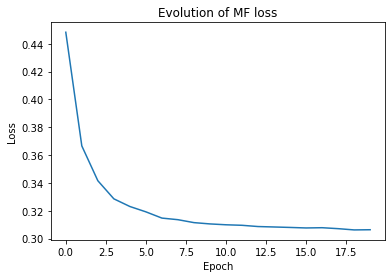

In [134]:
pd.Series(mf_losses).apply(np.mean).plot(title='Evolution of MF loss', xlabel='Epoch', ylabel='Loss');

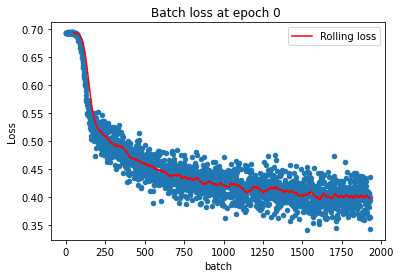

In [37]:
epoch = 0
epoch_loss_series = pd.Series(mf_losses[epoch], name='Loss').rename_axis('batch')
ax = epoch_loss_series.reset_index().plot.scatter(
    x='batch', y='Loss', title=f'Batch loss at epoch {epoch} '
)
epoch_loss_series.rolling(50).mean().reset_index().plot(
    ax=ax, x='batch', y='Loss', color='r', label='Rolling loss'
);


## Scoring

In [105]:
def mf_model_scoring(params, data, data_description):
    model = params
    model.eval()
    # prepare user and item index for scoring
    device = next(model.parameters()).device
    test_users = data_description['test_users']
    n_items = data_description['n_items']
    all_items = torch.arange(n_items, dtype=torch.int64, device=device)
    # perform scoring on a per-user basis
    scores = np.empty((len(test_users), n_items), dtype='f4')
    for user in test_users:
        test_user = torch.broadcast_to(torch.LongTensor([user]), (n_items,)).to(device)
        with torch.no_grad():
            predictions = model(test_user, all_items)
            scores[user, :] = predictions.detach().cpu().numpy()
    return scores

In [107]:
mf_scores = mf_model_scoring(mf_model, None, data_description)

## Evaluation

In [106]:
seen_data = training.loc[lambda x: x[data_index["users"].name].isin(data_description["test_users"])]

In [108]:
downvote_seen_items(mf_scores, seen_data, data_description)

In [109]:
mf_recs = topn_recommendations(mf_scores, topn=10)
model_evaluate(mf_recs, validation, data_description)

(0.05562913907284768, 0.017044307789340903, 0.8865784499054821)

# Bayesian Personalized Ranking

In [113]:
class BPRMF(MFBase):
    def forward(self, user, pos_item, neg_item=None):
        user = self.user_embeddings(user)
        pos_item = self.item_embeddings(pos_item)
        prediction_i = (user * pos_item).sum(dim=-1)
        if not self.training:  # support validation phase
            return prediction_i

        neg_item = self.item_embeddings(neg_item)
        prediction_j = (user * neg_item).sum(dim=-1)
        return prediction_i, prediction_j

In [114]:
bpr_data_loader = observations_loader(
    matrix_from_data(observed_data, data_description),
    batch_size=batch_size,
    n_neg_samples=1,
    data_factory=BPRDataset
)

In [115]:
batch = next(iter(bpr_data_loader))
batch

[tensor([4999, 1363, 2532,  ..., 5642,  720, 2084], device='cuda:0'),
 tensor([3348, 2460,   99,  ..., 3128, 2699, 1363], device='cuda:0'),
 tensor([3562, 1371, 3630,  ..., 1339, 1032,  273], device='cuda:0')]

## Training

In [126]:
def train_bprmf_epoch(loader, model, criterion, optimizer, scheduler=None):
    model.train()
    losses = []
    
    for (users, pos_items, neg_items) in loader:
        optimizer.zero_grad()
        loss = criterion(*model(users, pos_items, neg_items))
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().item())
    
    if scheduler is not None:
        scheduler.step()
    return losses

In [127]:
def prepare_bprmf_model(config, data_description):
    model = BPRMF(
        data_description['n_users'],
        data_description['n_items'],
        config['dim']
    )
    # transfer model to GPU if available
    device = None
    if torch.cuda.is_available():
        if not next(model.parameters()).is_cuda:
            model = model.cuda()
        device = next(model.parameters()).device
    # define loss function
    logsigmoid = nn.LogSigmoid().to(device)
    def criterion(pred_i, pred_j):
        return -logsigmoid(pred_i - pred_j).sum()
    # define optimizer
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr = config['learning_rate'],
        weight_decay=config['l2_reg']
    )
    return model, criterion, optimizer, device


def build_bprmf_model(config, data, data_description):
    '''Simple BPRMF training routine without early stopping'''
    model, criterion, optimizer, device = prepare_bprmf_model(config, data_description)
    data_loader = observations_loader(
        matrix_from_data(data, data_description),
        batch_size = batch_size,
        n_neg_samples = 1,
        data_factory = BPRDataset
    )
    
    losses = {}
    for epoch in tqdm(range(config['epochs'])):
        losses[epoch] = train_bprmf_epoch(data_loader, model, criterion, optimizer)
    return model, losses

In [128]:
bpr_model, bpr_losses = build_bprmf_model(config, observed_data, data_description)

100%|██████████| 20/20 [03:32<00:00, 10.65s/it]


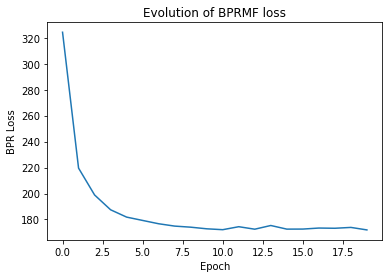

In [133]:
pd.Series(bpr_losses).apply(np.mean).plot(title='Evolution of BPRMF loss', xlabel='Epoch', ylabel='BPR Loss');

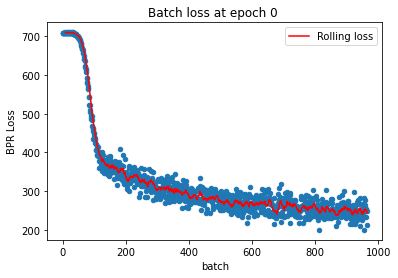

In [131]:
epoch = 0
epoch_loss_series = pd.Series(bpr_losses[epoch], name='BPR Loss').rename_axis('batch')
ax = epoch_loss_series.reset_index().plot.scatter(
    x='batch', y='BPR Loss', title=f'Batch loss at epoch {epoch} '
)
epoch_loss_series.rolling(10).mean().reset_index().plot(
    ax=ax, x='batch', y='BPR Loss', color='r', label='Rolling loss'
);


## Scoring

In [139]:
bprmf_scores = mf_model_scoring(bpr_model, None, data_description)

TypeError: forward() missing 1 required positional argument: 'neg_item'

## Evaluation

In [136]:
seen_data = training.loc[lambda x: x[data_index["users"].name].isin(data_description["test_users"])]

In [137]:
downvote_seen_items(mf_scores, seen_data, data_description)

In [138]:
mf_recs = topn_recommendations(mf_scores, topn=10)
model_evaluate(mf_recs, validation, data_description)

(0.05562913907284768, 0.017044307789340903, 0.8865784499054821)

# NeuralCF

In [ ]:
class NCF(nn.Module):
    '''
    The source for NCF code is taken form https://github.com/guoyang9/NCF.
    '''
    def __init__(
        self,
        user_num,
        item_num,
        factor_num,
        num_layers,
        dropout,
        model,
        GMF_model=None,
        MLP_model=None,
    ):
        super(NCF, self).__init__()
        """
        user_num: number of users;
        item_num: number of items;
        factor_num: number of predictive factors;
        num_layers: the number of layers in MLP model;
        dropout: dropout rate between fully connected layers;
        model: 'MLP', 'GMF', 'NeuMF-end', and 'NeuMF-pre';
        GMF_model: pre-trained GMF weights;
        MLP_model: pre-trained MLP weights.
        """
        self.dropout = dropout
        self.model = model
        self.GMF_model = GMF_model
        self.MLP_model = MLP_model

        self.embed_user_GMF = nn.Embedding(user_num, factor_num)
        self.embed_item_GMF = nn.Embedding(item_num, factor_num)
        self.embed_user_MLP = nn.Embedding(
            user_num, factor_num * (2 ** (num_layers - 1))
        )
        self.embed_item_MLP = nn.Embedding(
            item_num, factor_num * (2 ** (num_layers - 1))
        )

        MLP_modules = []
        for i in range(num_layers):
            input_size = factor_num * (2 ** (num_layers - i))
            MLP_modules.append(nn.Dropout(p=self.dropout))
            MLP_modules.append(nn.Linear(input_size, input_size // 2))
            MLP_modules.append(nn.ReLU())
        self.MLP_layers = nn.Sequential(*MLP_modules)

        if self.model in ["MLP", "GMF"]:
            predict_size = factor_num
        else:
            predict_size = factor_num * 2
        self.predict_layer = nn.Linear(predict_size, 1)

        self._init_weight_()

    def _init_weight_(self):
        """ We leave the weights initialization here. """
        if not self.model == "NeuMF-pre":
            nn.init.normal_(self.embed_user_GMF.weight, std=0.01)
            nn.init.normal_(self.embed_user_MLP.weight, std=0.01)
            nn.init.normal_(self.embed_item_GMF.weight, std=0.01)
            nn.init.normal_(self.embed_item_MLP.weight, std=0.01)

            for m in self.MLP_layers:
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)
            nn.init.kaiming_uniform_(
                self.predict_layer.weight, a=1, nonlinearity="sigmoid"
            )

            for m in self.modules():
                if isinstance(m, nn.Linear) and m.bias is not None:
                    m.bias.data.zero_()
        else:
            # embedding layers
            self.embed_user_GMF.weight.data.copy_(self.GMF_model.embed_user_GMF.weight)
            self.embed_item_GMF.weight.data.copy_(self.GMF_model.embed_item_GMF.weight)
            self.embed_user_MLP.weight.data.copy_(self.MLP_model.embed_user_MLP.weight)
            self.embed_item_MLP.weight.data.copy_(self.MLP_model.embed_item_MLP.weight)

            # mlp layers
            for (m1, m2) in zip(self.MLP_layers, self.MLP_model.MLP_layers):
                if isinstance(m1, nn.Linear) and isinstance(m2, nn.Linear):
                    m1.weight.data.copy_(m2.weight)
                    m1.bias.data.copy_(m2.bias)

            # predict layers
            predict_weight = torch.cat(
                [
                    self.GMF_model.predict_layer.weight,
                    self.MLP_model.predict_layer.weight,
                ],
                dim=1,
            )
            precit_bias = (
                self.GMF_model.predict_layer.bias + self.MLP_model.predict_layer.bias
            )

            self.predict_layer.weight.data.copy_(0.5 * predict_weight)
            self.predict_layer.bias.data.copy_(0.5 * precit_bias)

    def forward(self, user, item):
        if not self.model == "MLP":
            embed_user_GMF = self.embed_user_GMF(user)
            embed_item_GMF = self.embed_item_GMF(item)
            output_GMF = embed_user_GMF * embed_item_GMF
        if not self.model == "GMF":
            embed_user_MLP = self.embed_user_MLP(user)
            embed_item_MLP = self.embed_item_MLP(item)
            interaction = torch.cat((embed_user_MLP, embed_item_MLP), -1)
            output_MLP = self.MLP_layers(interaction)

        if self.model == "GMF":
            concat = output_GMF
        elif self.model == "MLP":
            concat = output_MLP
        else:
            concat = torch.cat((output_GMF, output_MLP), -1)

        prediction = self.predict_layer(concat)
        return prediction.view(-1)
